# Projet LEYENDA
## Livrable 1 - Classification Binaire

# 1-Importation des bibliothèques
On va regrouper ici l'ensemble des bibliothèques que nous allons utiliser dans ce notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import zipfile
import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom

from keras import Sequential

# 2-Préparation des images
#### Dézip des fichiers

In [2]:
import os
import zipfile

# Définition des chemins
repertoire = r'C:\Users\nicol\Downloads\DataScience\Dataset'
dossier_dataset = os.path.join(repertoire, 'Dataset')

# Création du dossier de destination s'il n'existe pas
if not os.path.exists(dossier_dataset):
    os.makedirs(dossier_dataset)

# Parcours des fichiers dans le répertoire
for fichier in os.listdir(repertoire):
    chemin_fichier = os.path.join(repertoire, fichier)
    
    # Vérification si c'est un fichier ZIP
    if zipfile.is_zipfile(chemin_fichier):
        with zipfile.ZipFile(chemin_fichier, 'r') as zip_ref:
            zip_ref.extractall(dossier_dataset)
            print(f'Fichier {fichier} décompressé dans le dossier {dossier_dataset}.')

print('Tous les fichiers ZIP ont été décompressés.')


Fichier Dataset Livrable 1 - Painting.zip décompressé dans le dossier C:\Users\nicol\Downloads\DataScience\Dataset\Dataset.
Fichier Dataset Livrable 1 - Photo.zip décompressé dans le dossier C:\Users\nicol\Downloads\DataScience\Dataset\Dataset.
Fichier Dataset Livrable 1 - Schematics.zip décompressé dans le dossier C:\Users\nicol\Downloads\DataScience\Dataset\Dataset.
Fichier Dataset Livrable 1 - Sketch.zip décompressé dans le dossier C:\Users\nicol\Downloads\DataScience\Dataset\Dataset.
Fichier Dataset Livrable 1 - Text.zip décompressé dans le dossier C:\Users\nicol\Downloads\DataScience\Dataset\Dataset.
Tous les fichiers ZIP ont été décompressés.


## Suppression des images corrompues

In [3]:
dataset_folder = dossier_dataset
print("Début de la vérification des images avec TensorFlow...")
for subdir, _, files in os.walk(dataset_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            # Tenter de charger et décoder l'image avec TensorFlow
            img = tf.io.read_file(file_path)
            img = tf.image.decode_image(img)
        except Exception as e:
            print(f"Image {file_path} is invalid for TensorFlow. Exception: {e}")
            try:
                os.remove(file_path)
                print(f"Removed: {file_path}")
            except Exception as e_rm:
                print(f"Error removing {file_path}. Exception: {e_rm}")

print("Vérification des images terminée.")

Début de la vérification des images avec TensorFlow...
Image C:\Users\nicol\Downloads\DataScience\Dataset\Dataset\Painting\painting_02662.jpg is invalid for TensorFlow. Exception: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage] name: 
Removed: C:\Users\nicol\Downloads\DataScience\Dataset\Dataset\Painting\painting_02662.jpg
Image C:\Users\nicol\Downloads\DataScience\Dataset\Dataset\Schematics\desktop.ini is invalid for TensorFlow. Exception: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 
Removed: C:\Users\nicol\Downloads\DataScience\Dataset\Dataset\Schematics\desktop.ini
Vérification des images terminée.


#### Emplacement du dataset
On spécifie ensuite l'emplacement du dataset et on met en place la variable data_dir.

In [4]:
datapath = dossier_dataset
data_dir = pathlib.Path(datapath)

### Création des Set
Pour commencer, on spécifie quelques paramètres pour l'apprentissage :
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>
On crée maintenant nos deux sets, un d'entraînement (80% des data) et un de test (20% des data).

In [5]:
image_h = 180
image_w = 180
batch_s = 32

In [6]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Found 41398 files belonging to 5 classes.
Using 8279 files for validation.


On en profite pour vérifier que les labels ont bien été trouvés :

In [7]:
class_names = train_set.class_names
print(class_names)

['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


# 3 - Coup d'œil sur nos données
On peut affichage une des images du set d'entraînements, aux dimensions spécifiées dans les paramètres :

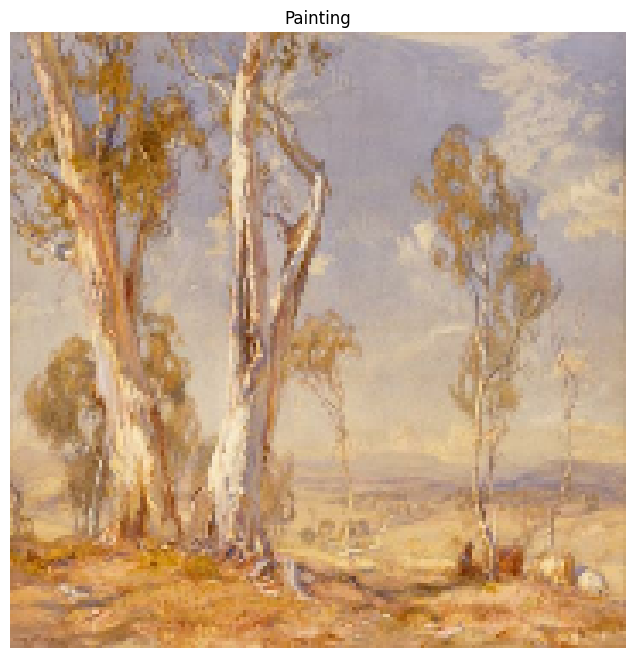

In [8]:
plt.figure(figsize=(8, 8))
for images, labels in train_set.take(2):
    for i in range(9):
        ax =  plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Il est maintenant temps de configurer notre environnement pour passer au vif du sujet.

# 4. Configuration de l'environnement pour l'entrainement
Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois. 
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Techniques de régularisation
Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones.

Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Dans le cadre de ce wokrshop nous verrons deux techniques de régularisation :
-	**L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
-	**La technique de dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.

In [10]:
data_augmentation = Sequential(
    [
        RandomFlip(mode="horizontal_and_vertical", input_shape=(image_h, image_w, 3)),
        RandomRotation(factor=0.18, fill_mode='reflect', interpolation='bilinear'),
        RandomZoom(height_factor=0.1, fill_mode='reflect', interpolation='bilinear')
    ]
)

c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 5. Réalisation d'un modèle CNN
On commence par crée la variable num_classes, elle sera égale au nombre de label que nous avons et sera utilisé pour déterminer le nombre de neurones sur la dernière couche.

In [11]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1,restore_best_weights=True)

On crée ensuite notre modèle en y implémentant l'ensemble des couches que nous souhaitons y intégrer :
- Un bloc convolutif contenant 16 filtres de hauteur et de largeur 3 avec une couche de Pooling.
- Un bloc convolutif similaire au précédent contenant 32 filtres de hauteur et de largeur de 3.
- Un bloc convolutif similaire au précédent contenant 64 filtres de hauteur et de largeur de 3.
- Une couche de DropOut
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 128.
- La couche finale complètement connectée (dense) retournant le résultat de la classification.

On peut ensuite compiler le modèle.

In [12]:
# Le modèle
epochs = 4
complete_model =  Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes) # 5 dans notre cas
])
# Ensure the input shape matches the previously built model
complete_model.build((None, 180, 180, 3))
# Compilation du modèle
complete_model.compile(optimizer =  'adam',
                       loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrainement du modèle
Maintenant que l'on dispose d'un modèle, on va pouvoir l'entraîner puis tester le modèle avec notre jeu de test.

In [13]:
# Entrainement du modèle
modele1 =  complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
)
acc = modele1.history['accuracy']
val_acc = modele1.history['val_accuracy']

loss = modele1.history['loss']
val_loss = modele1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/4
1035/1035 ━━━━━━━━━━━━━━━━━━━━ 356s 273ms/step - accuracy: 0.6300 - loss: 0.8552 - val_accuracy: 0.7933 - val_loss: 0.4975
Epoch 2/4
  42/1035 ━━━━━━━━━━━━━━━━━━━━ 4:50 293ms/step - accuracy: 0.7918 - loss: 0.4712

KeyboardInterrupt: 